# For this task:
* Choose a dataset from the provided list
* Explore/clean the data
* Exploratory Visualizations
    * Creating exploratory visualizations to understand your data and search for trends.
* Choose a model
    * Preprocess data
    * Fit and evaluate a default model
    * Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)
    * Add your observations in a Markdown: Do these features make sense based on the business case?
* Create Explanatory Visualizations for the most important features.
    * Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
    * The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
        * These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).
        * These will be added to your readme in part 4

---

# Context
Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

Attribute Information
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import os

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

# Functions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances



In [4]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax



In [5]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax


In [6]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict


In [7]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [8]:
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



# Load Data
* [Cirrhosis Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset)

In [9]:
fpath="Data/archive (2).zip"
df=pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Explore and Clean Data
- Drop ID column
- Going to check for duplicates
- Checking for NA values
    - 106 cases did not particapate in the study but consented to have basic measurements recorded and to be followed for survival
        - Are these cases useful?
- .describe() on numerical data to find outliers
- Identify columns that have binary values
    - Address these columns


In [10]:
del df['ID']
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [11]:
df.duplicated().sum()

0

- *no duplicates*

In [12]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

 - use missingno to get a better view of the NA's

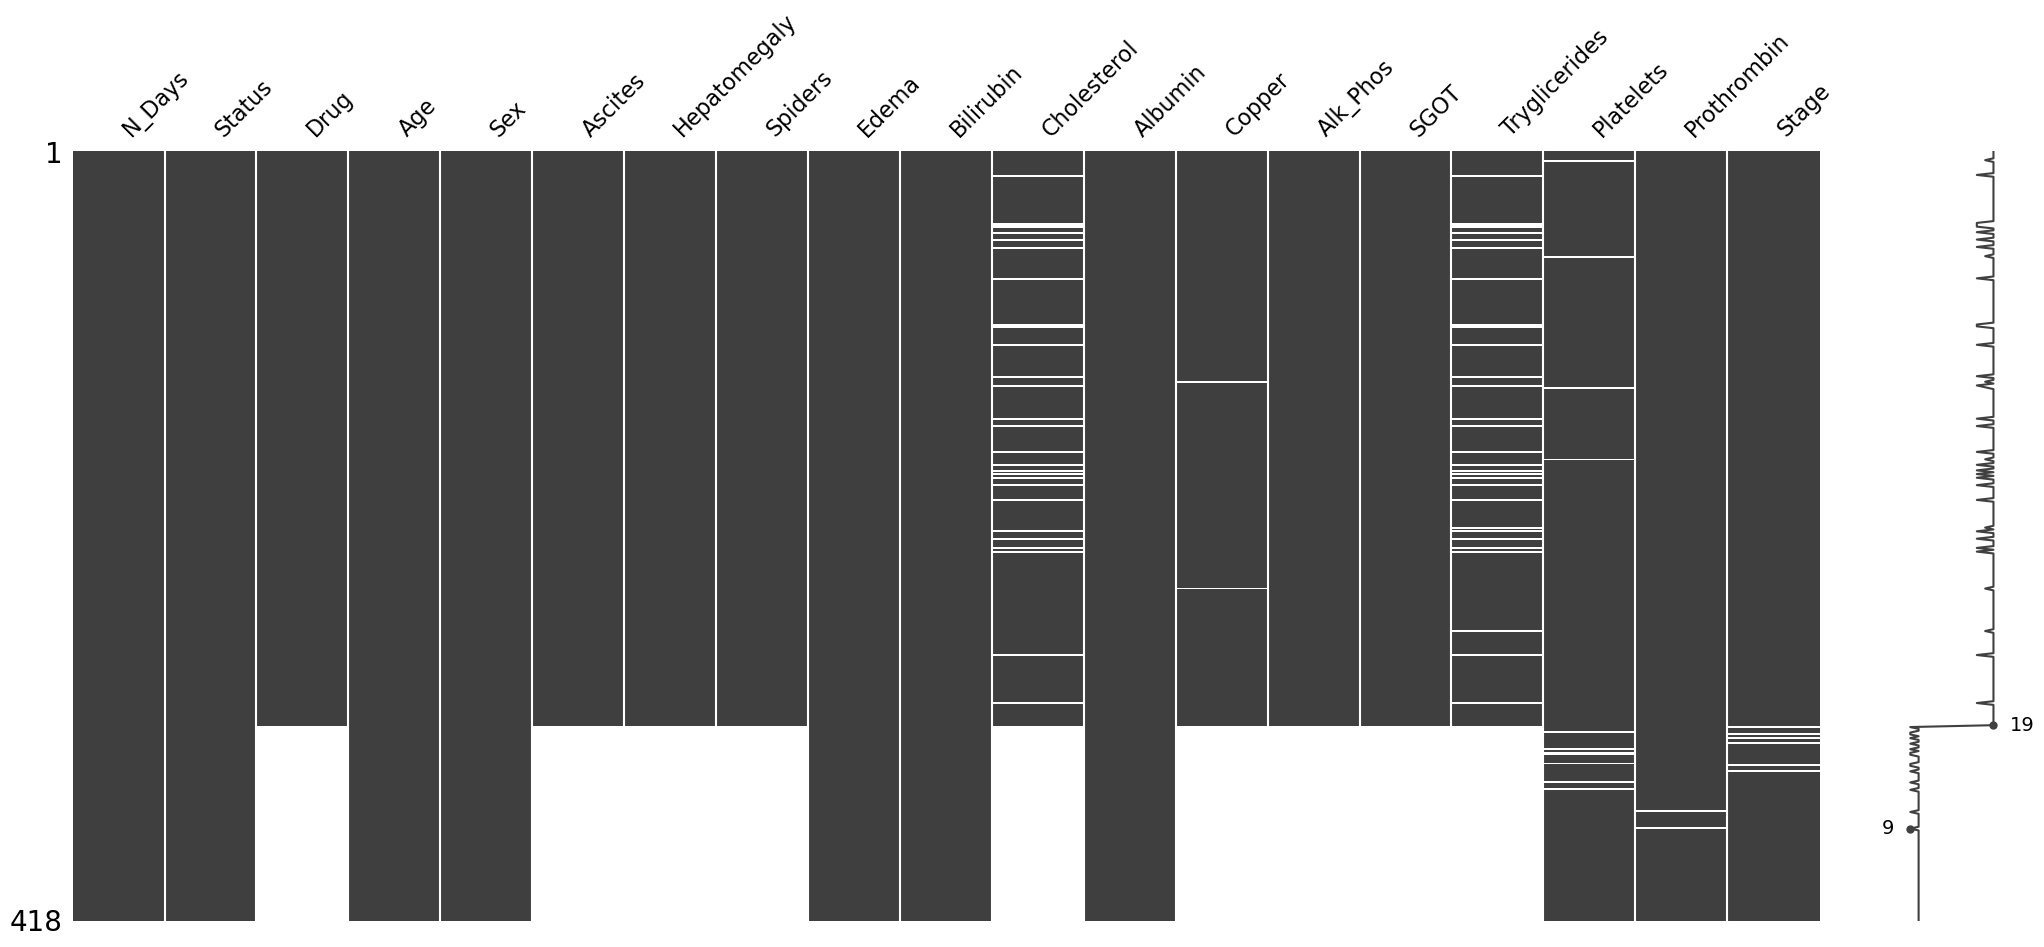

In [13]:
missingno.matrix(df);

- Decided to drop the group of 106 non-participants

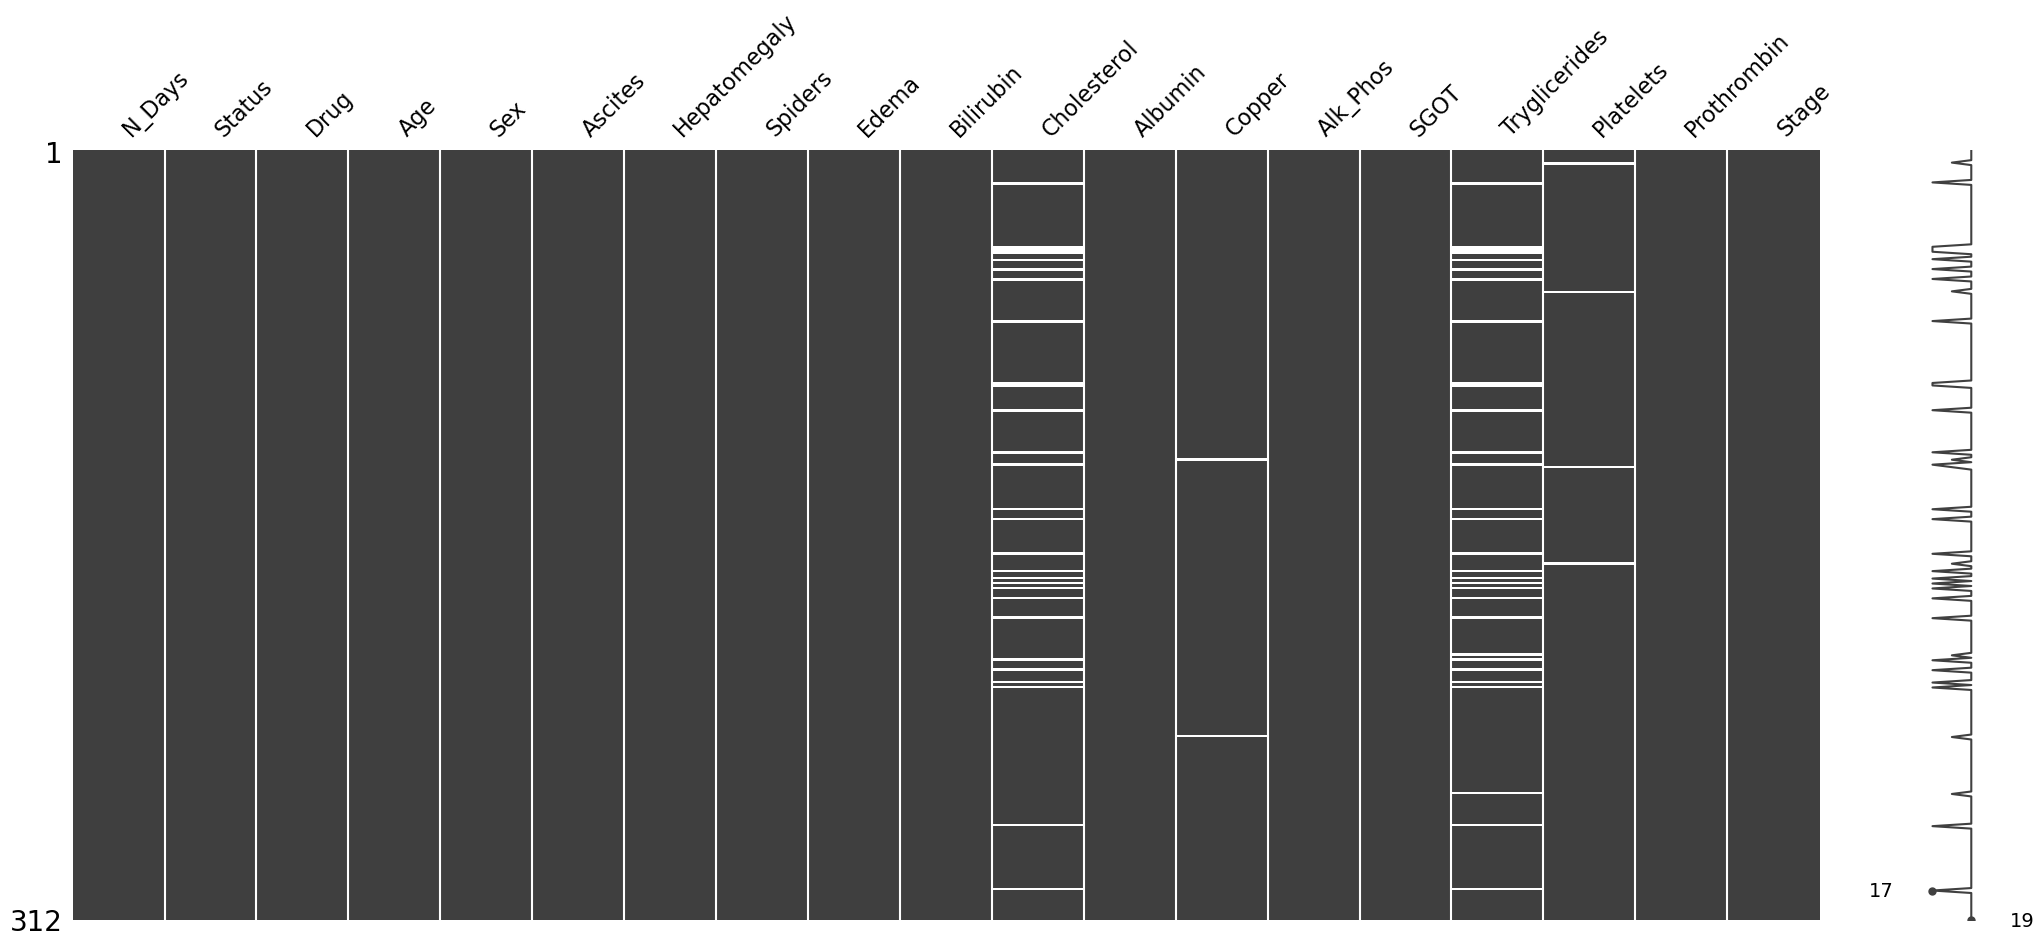

In [14]:
df=df.dropna(subset=['Drug'])
missingno.matrix(df);

# Will use simple imputer to fill the rest of the NA with median

In [15]:
df.describe(exclude='number')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,312,312,312,312,312,312,312
unique,3,2,2,2,2,2,3
top,C,D-penicillamine,F,N,Y,N,N
freq,168,158,276,288,160,222,263


- Status & Edema have 3 values
    - Change to Binary
        - Status to Alive(C,CL):1 OR Died(D):0
        - Edema to Y(Y):1 OR N(S,N):0

In [16]:
df['Status'].value_counts()

C     168
D     125
CL     19
Name: Status, dtype: int64

### Option: "Status" to binary
- Going to use RandomForestClassifier
    - If not happy with results may look at Logistic Regression

In [17]:
df['Status'] = df['Status'].replace({'C':1,'CL':1,"D":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [18]:
df['Edema'].value_counts(dropna=False)

N    263
S     29
Y     20
Name: Edema, dtype: int64

In [19]:
df['Edema'] = df['Edema'].replace({'N':0,'S':0,'Y':1})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,D-penicillamine,21464,F,Y,Y,Y,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,D-penicillamine,20617,F,N,Y,Y,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,D-penicillamine,25594,M,N,N,N,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,D-penicillamine,19994,F,N,Y,Y,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,Placebo,13918,F,N,Y,Y,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


- What are the values of 'Drug'

## Binary Encoding

In [20]:
df['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

In [21]:
df = df.replace({'F':0,'M':1,'D-penicillamine':1,'Placebo':0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,21464,0,Y,Y,Y,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,20617,0,N,Y,Y,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,25594,1,N,N,N,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,19994,0,N,Y,Y,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,13918,0,N,Y,Y,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [22]:
yn_col=['Ascites','Hepatomegaly','Spiders']
df[yn_col] = df[yn_col].replace({'Y':1,"N":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,25594,1,0,0,0,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,19994,0,0,1,1,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Convert Age into Years

In [23]:
df['Age']=df['Age']//360
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,57,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,71,1,0,0,0,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,55,0,0,1,1,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,38,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


# Outlires
- np.log to address

In [24]:
df.describe()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,284.000000,312.000000,310.000000,312.000000,312.000000,282.000000,308.000000,312.000000,312.000000
mean,2006.362179,0.599359,0.506410,50.250000,0.115385,0.076923,0.512821,0.288462,0.064103,3.256090,369.510563,3.520000,97.648387,1982.655769,122.556346,124.702128,261.935065,10.725641,3.032051
std,1123.280843,0.490816,0.500762,10.732422,0.319999,0.266897,0.500639,0.453775,0.245329,4.530315,231.944545,0.419892,85.613920,2140.388824,56.699525,65.148639,95.608742,1.004323,0.877880
min,41.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1191.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,249.500000,3.310000,41.250000,871.500000,80.600000,84.250000,199.750000,10.000000,2.000000
50%,1839.500000,1.000000,1.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000,3.000000
75%,2697.250000,1.000000,1.000000,57.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.425000,400.000000,3.800000,123.000000,1980.000000,151.900000,151.000000,322.500000,11.100000,4.000000
max,4556.000000,1.000000,1.000000,79.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


### Outliers (7)
- Bilirubin
- Cholesterol
- Copper
- Alk_Phos
- SGOT
- Tryglicerides
- Prothrombin

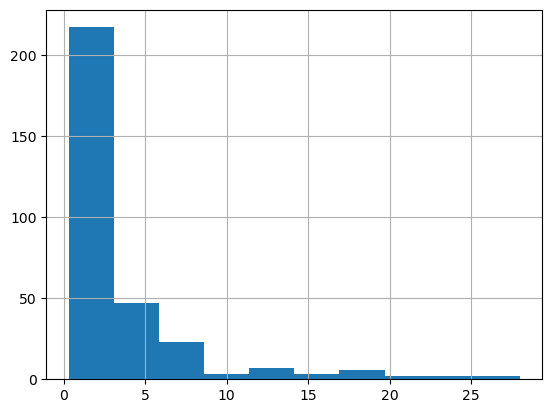

In [25]:
df["Bilirubin"].hist();

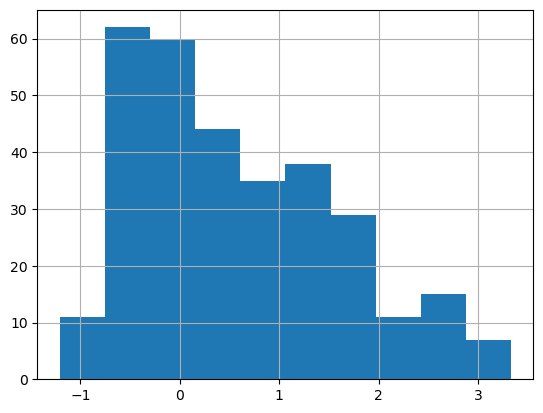

In [26]:
df['Bilirubin']=np.log(df['Bilirubin'])
df['Bilirubin'].hist();

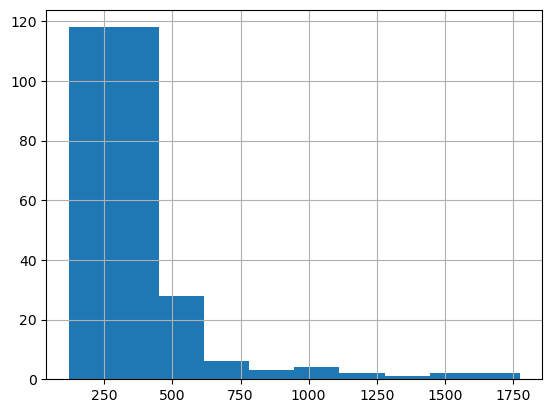

In [27]:
df['Cholesterol'].hist();

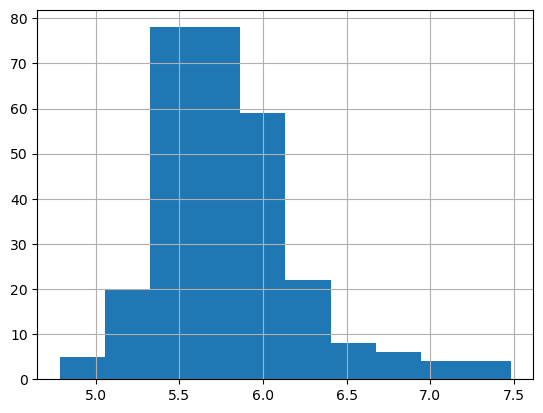

In [28]:
df['Cholesterol']=np.log(df['Cholesterol'])
df['Cholesterol'].hist();

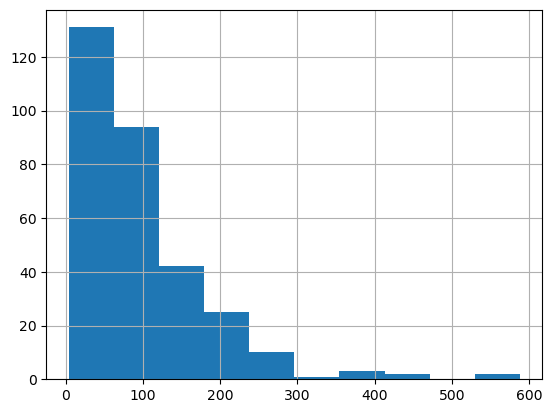

In [29]:
df['Copper'].hist();

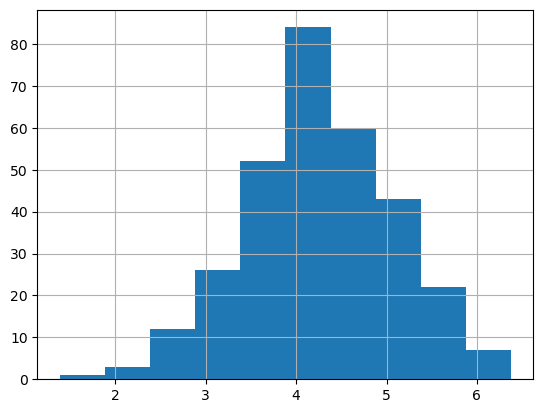

In [30]:
df['Copper']=np.log(df['Copper'])
df['Copper'].hist();

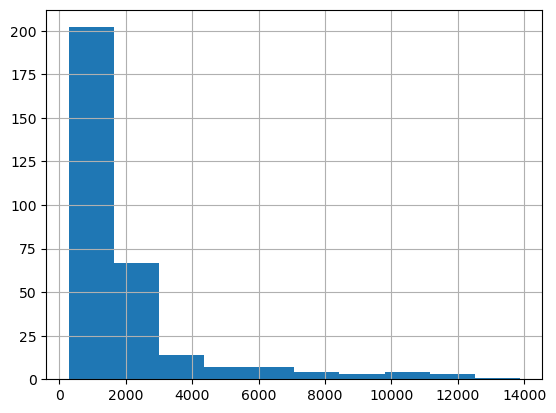

In [31]:
df['Alk_Phos'].hist();

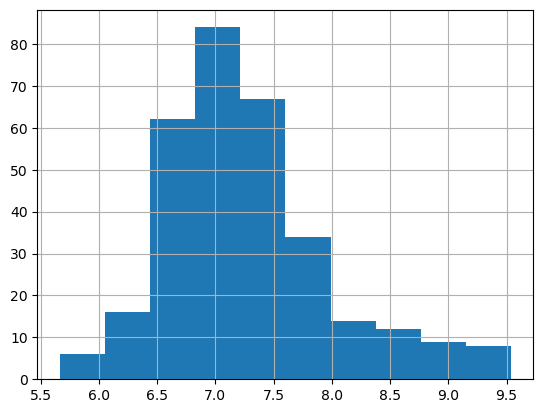

In [32]:
df['Alk_Phos']=np.log(df['Alk_Phos'])
df['Alk_Phos'].hist();

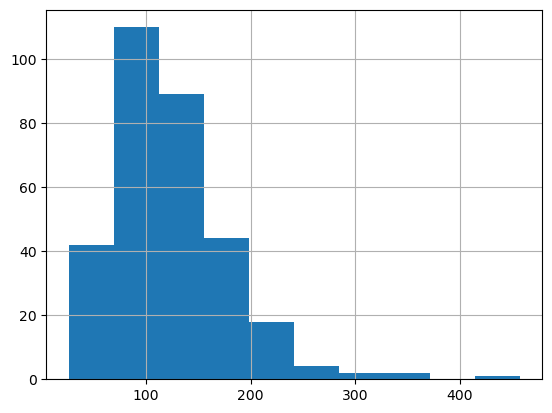

In [33]:
df['SGOT'].hist();

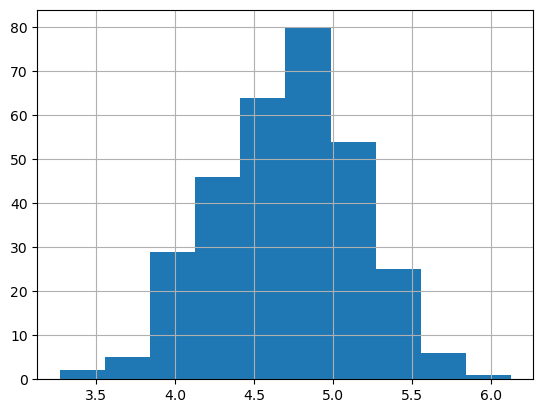

In [34]:
df['SGOT'] = np.log(df['SGOT'])
df['SGOT'].hist();

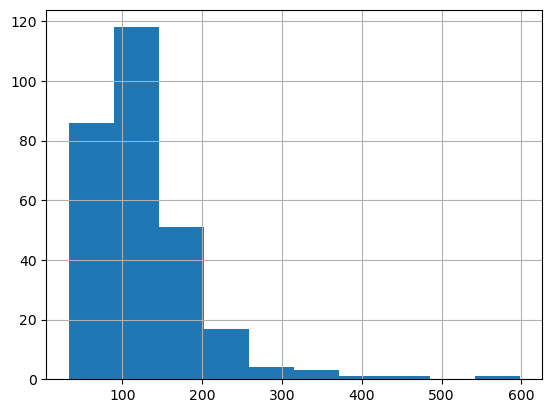

In [35]:
df['Tryglicerides'].hist();

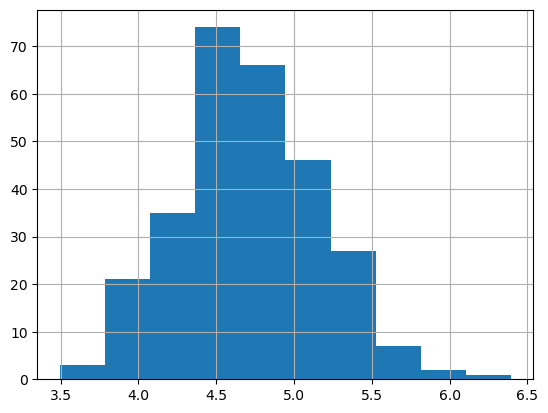

In [36]:
df['Tryglicerides'] = np.log(df['Tryglicerides'])
df['Tryglicerides'].hist();

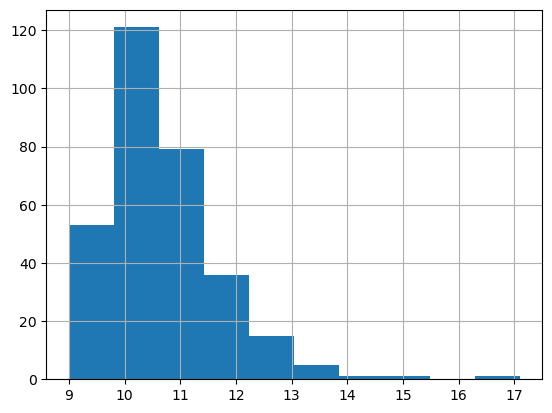

In [37]:
df['Prothrombin'].hist();

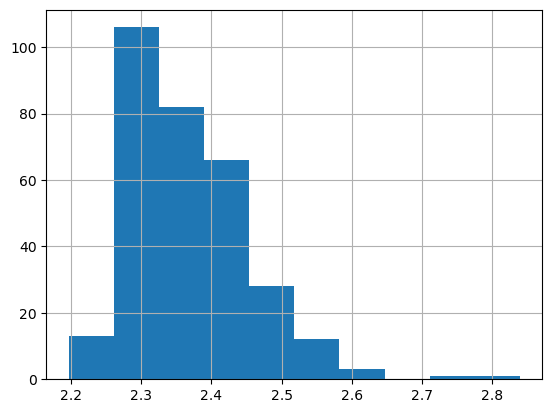

In [38]:
df['Prothrombin'] = np.log(df['Prothrombin'])
df['Prothrombin'].hist();

# Saving cleaned data

In [41]:
csv_file_path = os.path.join('Data', 'cleaned_data.csv')

df.to_csv(csv_file_path, index=False)

# TTS

In [42]:
target = 'Status'
y = df[target].copy()
X = df.drop(columns=target)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
119,2033,1,35,1,0,0,0,0,1.252763,5.783825,3.98,6.095825,6.641182,4.869072,5.347108,344.0,2.360854,3.0
258,1615,0,60,0,0,1,0,0,1.131402,5.624018,2.97,3.737670,7.012115,4.828314,4.836282,221.0,2.282382,3.0
244,1790,0,46,0,0,1,0,0,-0.510826,5.609472,3.65,3.871201,6.677083,3.964615,5.365976,305.0,2.261763,3.0
204,2081,1,49,0,1,0,0,0,0.916291,5.945421,3.55,4.682131,7.323831,5.475208,NaN,126.0,2.332144,3.0
137,1297,1,51,1,0,1,0,0,1.987874,6.054439,3.93,5.568345,7.793174,4.981550,5.384495,252.0,2.351375,3.0


In [43]:
df[target].value_counts(normalize=True)

1    0.599359
0    0.400641
Name: Status, dtype: float64

## Import SMOTE

# Class imblance
- Calling SMOTE to deal with imbalances

In [44]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
from imblearn.pipeline import make_pipeline

# Numeric
- All data but target numeric

In [45]:
num_cols = X_train.select_dtypes('number').columns
print('\n -', num_cols)
impute_median = SimpleImputer(strategy = 'median')
scaler = StandardScaler()
rf_clf = RandomForestClassifier(random_state=42)

# Make Pipeline
rf_pipe = make_pipeline(impute_median,scaler,smote,rf_clf)


 - Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage'],
      dtype='object')


In [46]:
rf_pipe.fit(X_train,y_train)
rf_pipe.score(X_test,y_test)

0.7692307692307693

# DO I NEED A PREPROCESSON?  WAS NOT SURE HOW TO FIT NUM_PIPE ON TO X_TRAIN AND WHAT AOBUT THE VERBOSE_FEATURE OPTION?

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       141

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



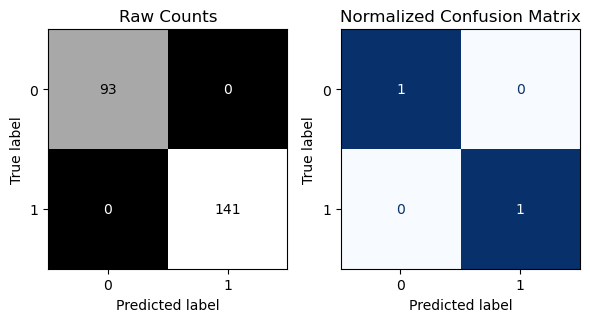


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.80      0.85      0.82        46

    accuracy                           0.78        78
   macro avg       0.78      0.77      0.77        78
weighted avg       0.78      0.78      0.78        78



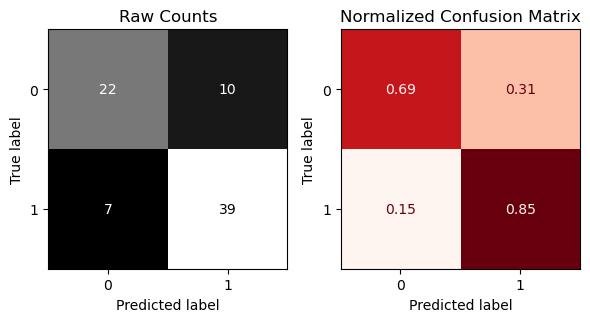

In [47]:
rf_pipe.fit(X_train,y_train)
evaluate_classification(rf_pipe,X_train,y_train,X_test,y_test)

# Permutation

In [48]:
# Checking the number of feature importances matches the # of columns
print(len(rf_clf.feature_importances_))
print(len(X_train.columns))
len(rf_clf.feature_importances_) == len(X_train.columns)



18
18


True

In [49]:
feature_name = rf_pipe[-1].feature_names_in_

In [50]:
importances = pd.Series(rf_pipe[-1].feature_importances_,index=feature_name, name="Featrue Importance")
importances

N_Days           0.165087
Drug             0.009894
Age              0.049163
Sex              0.027810
Ascites          0.016604
Hepatomegaly     0.038803
Spiders          0.004490
Edema            0.009828
Bilirubin        0.126151
Cholesterol      0.048594
Albumin          0.051292
Copper           0.100118
Alk_Phos         0.054315
SGOT             0.058238
Tryglicerides    0.042690
Platelets        0.046053
Prothrombin      0.118691
Stage            0.032180
Name: Featrue Importance, dtype: float64

In [51]:
importances = get_importances(rf_pipe[-1],sort=True,ascending=False)
importances

N_Days           0.165087
Bilirubin        0.126151
Prothrombin      0.118691
Copper           0.100118
SGOT             0.058238
Alk_Phos         0.054315
Albumin          0.051292
Age              0.049163
Cholesterol      0.048594
Platelets        0.046053
Tryglicerides    0.042690
Hepatomegaly     0.038803
Stage            0.032180
Sex              0.027810
Ascites          0.016604
Drug             0.009894
Edema            0.009828
Spiders          0.004490
Name: Feature Importance, dtype: float64

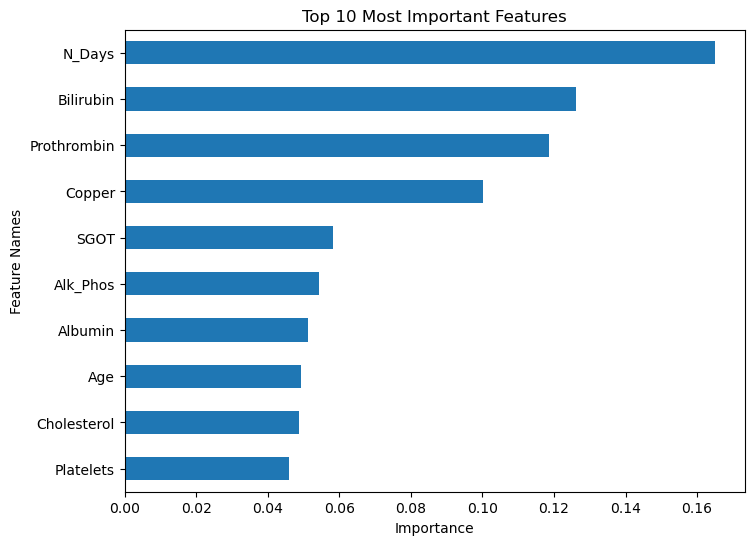

In [52]:
plot_importance(importances,top_n=10);

In [53]:
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_pipe, X_test, y_test,n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [54]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=rf_pipe[-1].feature_names_in_,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

Prothrombin      0.025641
N_Days           0.010256
Age              0.010256
Platelets        0.010256
Hepatomegaly     0.010256
Alk_Phos         0.005128
Bilirubin        0.002564
Cholesterol      0.002564
SGOT             0.002564
Edema            0.000000
Drug             0.000000
Spiders          0.000000
Sex              0.000000
Stage            0.000000
Tryglicerides   -0.002564
Ascites         -0.007692
Copper          -0.017949
Albumin         -0.023077
Name: permutation importance, dtype: float64

In [55]:
colors_top10 = get_color_dict(importances, top_n=10)
colors_top10

{'N_Days': 'green',
 'Bilirubin': 'green',
 'Prothrombin': 'green',
 'Copper': 'green',
 'SGOT': 'green',
 'Alk_Phos': 'green',
 'Albumin': 'green',
 'Age': 'green',
 'Cholesterol': 'green',
 'Platelets': 'green',
 'Tryglicerides': '#006ba4',
 'Hepatomegaly': '#006ba4',
 'Stage': '#006ba4',
 'Sex': '#006ba4',
 'Ascites': '#006ba4',
 'Drug': '#006ba4',
 'Edema': '#006ba4',
 'Spiders': '#006ba4'}

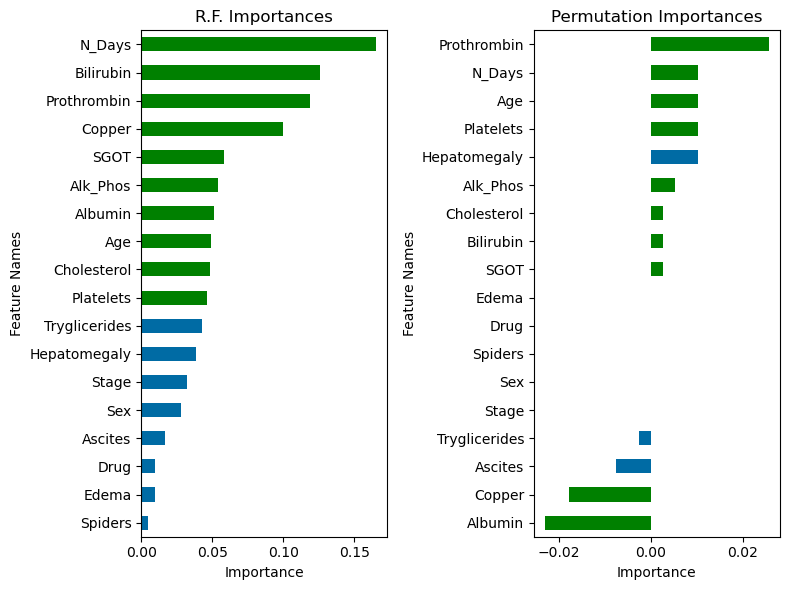

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 20 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top10)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top10)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()



- R.F. Importance seem to be bias to catagorical features
    - Only one out of the top 10 is a catagorical/discrete feature
        - Stage (9)
- Permutation has 2 catagorial/discrete feature in the to 10
    - Stage (5)
    - Spiders (10)

In [57]:
df['Stage'].value_counts()

3.0    120
4.0    109
2.0     67
1.0     16
Name: Stage, dtype: int64

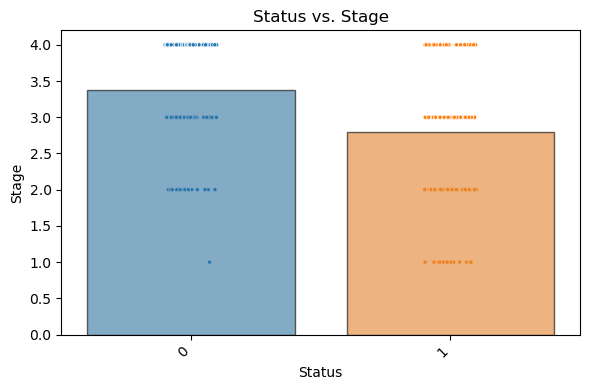

In [58]:
plot_categorical_vs_target(df, 'Status','Stage');

- Cirrhosis is a late stage of scarring (fibrosis) of the liver
    - Status 0 repsents deaths
    - Test group was made up of mostly late stage Cirrhosis
    - High correlation to stage 3/4 and death

/var/folders/zd/1wqdzm7d7d13shmcygx_4src0000gn/T/ipykernel_1234/605793594.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


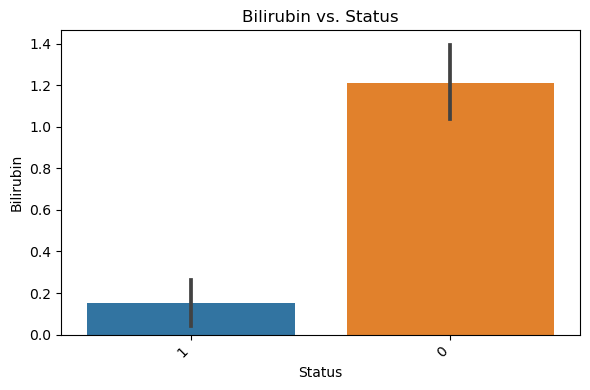

In [59]:
#plot_numeric_vs_target(df, 'Bilirubin', 'Status');# Add sorting the target's categories
plot_numeric_vs_target(df,'Bilirubin', 'Status',target_type = 'class',sorted=True, ascending=True);



- High Bilirubin levels usually means severe liver disease and possibly cirrhosis
    - Stage 3 is usually where jaundice happens
    - As shown above stage 3/4 have a higher death rate

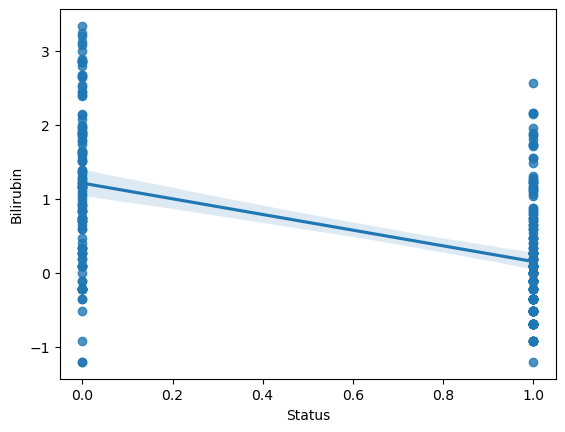

In [60]:
sns.regplot(data=df, x='Status',y='Bilirubin');


/var/folders/zd/1wqdzm7d7d13shmcygx_4src0000gn/T/ipykernel_1234/605793594.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


- Excluding 4 NaN's


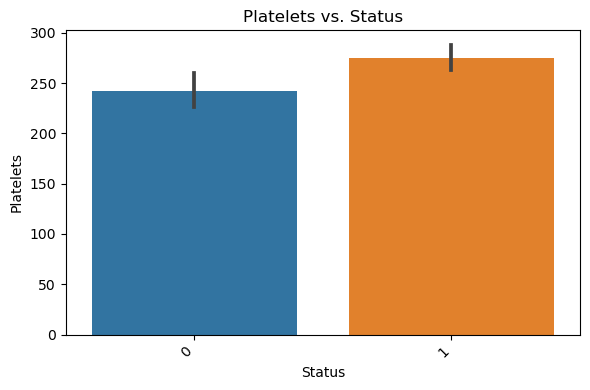

In [61]:
plot_numeric_vs_target(df,'Platelets', 'Status',target_type = 'class',sorted=True, ascending=True);

/var/folders/zd/1wqdzm7d7d13shmcygx_4src0000gn/T/ipykernel_1234/605793594.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


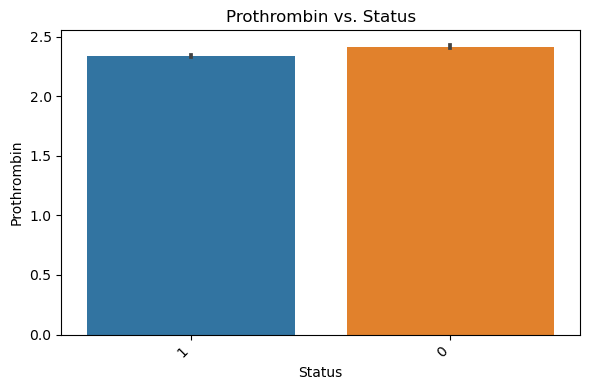

In [62]:
plot_numeric_vs_target(df,'Prothrombin', 'Status',target_type = 'class',sorted=True, ascending=True);

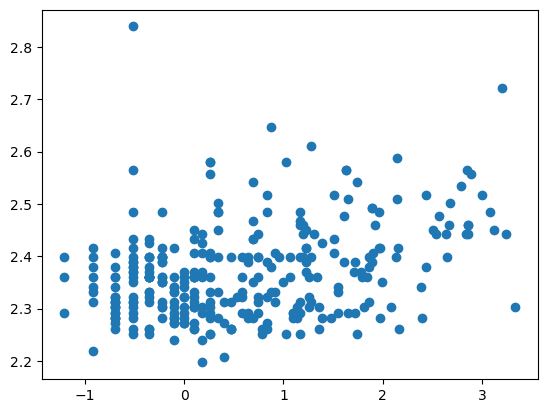

In [63]:
plt.scatter(df['Bilirubin'],df[ 'Prothrombin']);